## 題目介紹 - Titanic: Machine Learning from Disaster

1. to predict if a passenger survived the sinking of the Titanic or not.
2. 二元分類問題

![](https://static1.squarespace.com/static/5006453fe4b09ef2252ba068/t/5090b249e4b047ba54dfd258/1351660113175/TItanic-Survival-Infographic.jpg?format=800w)

## 使用的套件及data讀取

In [120]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

# read data
path = "/Users/chad/visualprojects/kaggle/titiantic/"
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")

## 資料探勘

In [121]:
train.head(3)
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [122]:
train.info()
test.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


1. training set 中 Age/Cabin/Embarked 有missing value
2. testing set 中 Age/Fare/Cabin 有missing value
3. Name/Sex/Ticket/Cabin/Embarked 皆為object屬性（可能無序離散值）
***
資料視覺化 - 初步相關係數

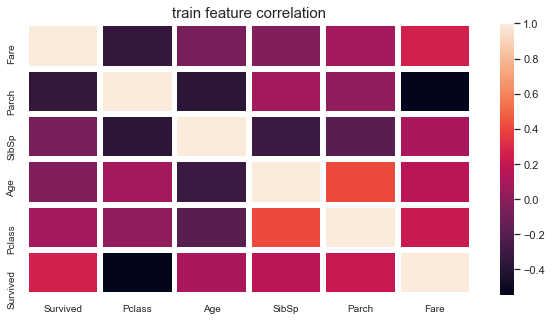

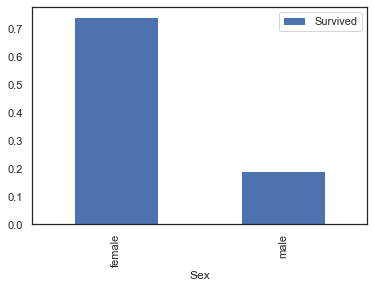

In [129]:
f, ax = plt.subplots(figsize=(10,5))
train_corr = train.drop("PassengerId", axis=1).corr()
sns.heatmap(train_corr, linewidths=5)
ax.set_xticklabels(train_corr.index, size=10)
ax.set_yticklabels(train_corr.columns[::-1], size=10)
ax.set_title('train feature correlation', fontsize=15)

sex_pivot = train.pivot_table(index="Sex", values="Survived")
sex_pivot.plot.bar()
plt.show()

1. Pclass與Fare 呈現負相關 -> 票價貴則艙別等級高且少
2. Survived與Fare 呈現正相關 -> 票貴則生還率高 
3. Survived與Age 呈現正相關 -> 長者獲救機率高
4. 女性生還率比男性高

**小結**
推測生還率可能與 1. 年齡 2. 艙別 3. 性別有關係（三者可考慮納入特徵）

### EDA - 年齡（數據觀察）

1-1. ***年齡生還分佈圖***

1-2. 年齡性別曲線

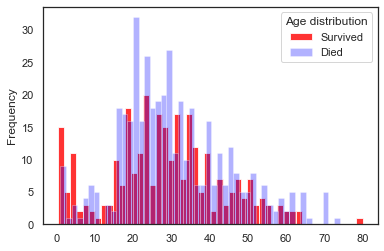

In [106]:
survived = train[train["Survived"]==1]
died = train[train["Survived"]==0]
survived["Age"].plot.hist(alpha=0.8,color="red",bins=50)
died["Age"].plot.hist(alpha=0.3,color="blue",bins=50)
plt.legend(["Survived", "Died"], title="Age distribution")
plt.show()


1. 小孩與年紀偏大生還率較高
2. 年紀與生還率並非線性
***
1-1. 年齡分佈圖

1-2. ***年齡性別曲線***

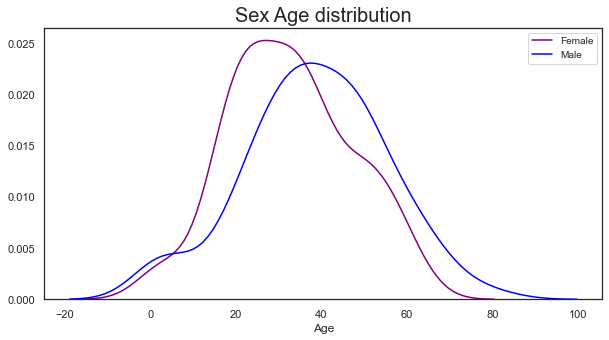

In [107]:
f, ax = plt.subplots(figsize=(10,5))
ax.set_title("Sex Age distribution", size=20)
sns.distplot(train[train["Sex"]=="female"].dropna().Age, color="purple", label="Female", hist=False)
sns.distplot(train[train["Sex"]=="male"].dropna().Age, color="blue", label="Male", hist=False)
ax.legend(fontsize=10)

1. 男性中年人居多
2. 女性年輕化
3. 小男孩較多
***
數據預處理 - missing value & 年齡分類

其中Pclass/Sex/Age_categories 為無序離散值，故採one hot encoding轉為虛擬變量

In [108]:
def deal_age(df):       #fill missing value
    df["Age"] = df["Age"].fillna(-0.5)      # try -0.5 -> 0
    cut_points = [-1, 0, 5, 12, 18, 35, 60, 100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df['Age_categories'] = pd.cut(df['Age'], cut_points, labels=label_names)
    return df

def build_dummies(df, column_name):
    dummies = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df, dummies], axis=1)
    return df

train = deal_age(train)
test = deal_age(test)

for col in ["Age_categories", "Pclass", "Sex"]:
    train = build_dummies(train, col)
    test = build_dummies(test, col)

### EDA - 艙別

2-1. ***艙別與年齡分佈圖***

2-2. 艙別與生還率分佈

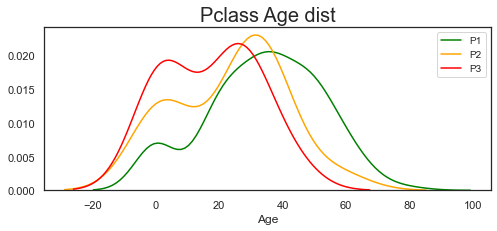

In [109]:
f, ax = plt.subplots(figsize=(8,3))
ax.set_title("Pclass Age dist", size=20)
sns.distplot(train[train["Pclass"]==1].dropna().Age, color="green", label="P1", hist=False)
sns.distplot(train[train["Pclass"]==2].dropna().Age, color="orange", label="P2", hist=False)
sns.distplot(train[train["Pclass"]==3].dropna().Age, color="red", label="P3", hist=False)
ax.legend(fontsize=10)

1. 艙位等級高，年齡也越高
***
2-1. 艙別與年齡分佈圖

2-2. ***艙別與生還率分佈***

Text(0.5, 1.0, 'Pclass survived count')

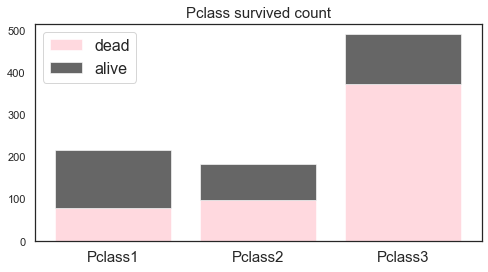

In [110]:
pclass = [1,2,3]
dead_count = died.groupby("Pclass")["Survived"].count()
alive_count = survived.groupby("Pclass")["Survived"].count()
ax = plt.figure(figsize=(8,4)).add_subplot(111)
ax.bar(pclass, dead_count, color="pink", alpha=0.6, label = 'dead')
ax.bar(pclass, alive_count, color="black", bottom=dead_count, alpha=0.6, label = 'alive')
ax.legend(fontsize=16)
ax.set_xticks(pclass)
ax.set_xticklabels(["Pclass1", "Pclass2", "Pclass3"], size=15)
ax.set_title("Pclass survived count", size=15)

1. Pclass3 dead/alive 相對比例最高
2. 獲救比例看起來頭等艙較高
***
### EDA - 性別

3-1. ***性別與年齡分佈***

3-2. 艙別與性別

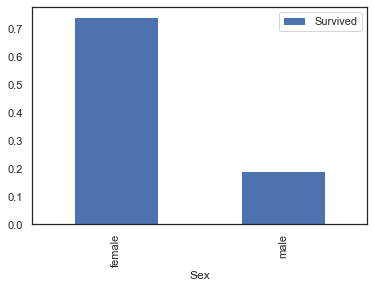

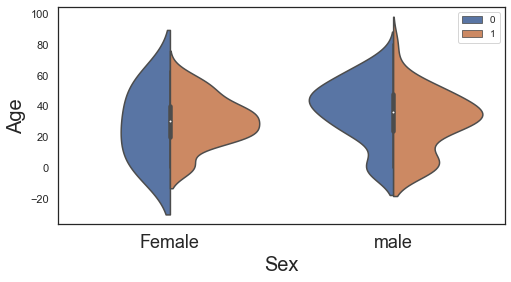

In [111]:
sex_pivot = train.pivot_table(index="Sex", values="Survived")
sex_pivot.plot.bar()
plt.show()

ax = plt.figure(figsize=(8,4)).add_subplot(111)
sns.violinplot(x='Sex', y='Age', hue='Survived', data=train.dropna(), split=True)
ax.set_xlabel('Sex',size=20)
ax.set_xticklabels(['Female','male'], size=18)
ax.set_ylabel('Age',size=20)
ax.legend(fontsize=10)

1. 女性中獲救年齡在中段
2. 男性中年齡小生還率較高/中壯年死亡率高
***
3-1. 性別與年齡分佈

3-2. ***艙別與性別***

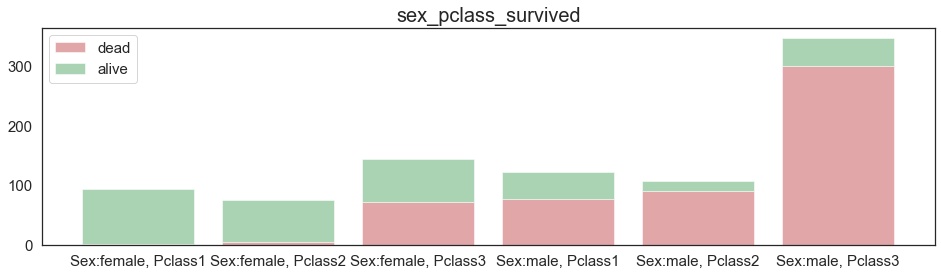

In [132]:
label = ["Sex:female, Pclass1", "Sex:female, Pclass2", "Sex:female, Pclass3","Sex:male, Pclass1", "Sex:male, Pclass2", "Sex:male, Pclass3"]

pos = range(6)
ax = plt.figure(figsize=(16,4)).add_subplot(111)
ax.bar(pos, 
        train[train['Survived']==0].groupby(['Sex','Pclass'])['Survived'].count().values, 
        color='r', 
        alpha=0.5, 
        align='center',
        tick_label=label, 
        label='dead')
ax.bar(pos, 
        train[train['Survived']==1].groupby(['Sex','Pclass'])['Survived'].count().values, 
        bottom=train[train['Survived']==0].groupby(['Sex','Pclass'])['Survived'].count().values,
        color='g',
        alpha=0.5,
        align='center',
        tick_label=label, 
        label='alive')
ax.tick_params(labelsize=15)
ax.set_title('sex_pclass_survived', size=20)
ax.legend(fontsize=15)

1. 女性較容易獲救
2. 同性別下，艙別越高，則***相對獲救率越高***
***
### 基於上述EDA
1. 將三類(年齡/性別/艙別)納入feature
2. 艙別與票價有直接關係，故也納入feauture

### 其餘特徵值處理
1. ***Fare/Embarked missing value處理***
2. 觀察'SibSp','Parch','Embarked'

In [113]:
test["Fare"] = test["Fare"].fillna(train["Fare"].mean())
train["Embarked"] = train["Embarked"].fillna("S")   #train中有一筆missing value

1. Fare/Embarked missing value處理
2. ***觀察'SibSp','Parch','Embarked'***

In [114]:
column = ['SibSp','Parch','Embarked']
print(train[column].describe(include='all', percentiles=[]))

SibSp       Parch Embarked
count   891.000000  891.000000      891
unique         NaN         NaN        3
top            NaN         NaN        S
freq           NaN         NaN      646
mean      0.523008    0.381594      NaN
std       1.102743    0.806057      NaN
min       0.000000    0.000000      NaN
50%       0.000000    0.000000      NaN
max       8.000000    6.000000      NaN


觀察後特性：'SibSp','Parch'值範圍為離散值, 'Embarked'為str

1. Embarked採one hot encoding
2. 避免值影響model訓練，故採數據標準化（歸於同一量級）
    1. 提升模型的收斂速度
    2. 提高模型的精準度
    3. 讓三個特徵值對模型擁有相同貢獻度
    
<img src="https://s3.amazonaws.com/dq-content/186/rescaling.svg" width="500">
<img src="https://raw.githubusercontent.com/ritchieng/machine-learning-stanford/master/w2_linear_regression_multiple/gradientdescent_scale.png" width="500">



In [115]:
from sklearn.preprocessing import minmax_scale

columns = ["SibSp","Parch","Fare"]

train = build_dummies(train, "Embarked")
test = build_dummies(test, "Embarked")

for col in columns:
    train[col+ "_scaled"] = minmax_scale(train[col])
    test[col+ "_scaled"] = minmax_scale(test[col])

## 模型訓練

基於上述觀察採取可能特徵值如下

1. 由於為二元分類問題，採線性迴歸訓練模型

[[-0.38592968  1.83025455  0.31730727 -0.2179581  -0.04893957 -0.56375719
  -0.9309081   0.96685081  0.05896997 -1.0257516   1.33811235 -1.33804317
   0.17040381  0.16809182 -0.33842646 -1.75604017 -0.78286642  0.5356959 ]]
[0.55780411]


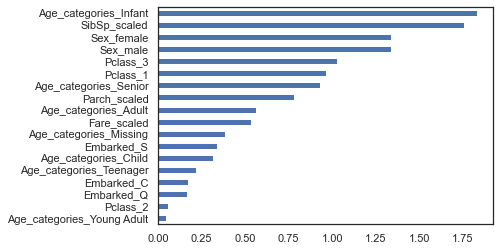

In [116]:
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']

lr = LogisticRegression()
lr.fit(train[columns], train["Survived"])

coefficients = lr.coef_ ## y = ax + b for a
intercept = lr.intercept_ ## y = ax + b for b
print(coefficients)
print(intercept)

feature_importannce = pd.Series(coefficients[0], index=train[columns].columns)
ordered_feature_importance = feature_importannce.abs().sort_values()
ordered_feature_importance.plot.barh()
plt.show()

## 模型夜戰

採取前八個相關係數較高的特徵值

1. 交叉驗證模型
2. 並轉出結果檔

In [117]:
from sklearn.model_selection import cross_val_score

columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']
all_x = train[columns]
all_y = train["Survived"]

lr = LogisticRegression()
lr.fit(all_x, all_y)
test_predicitions = lr.predict(test[columns])
test_ids = test["PassengerId"]

scores = cross_val_score(lr, all_x, all_y, cv=10) 
accuracy = scores.mean()
print(accuracy)

submission_df = {"PassengerId": test_ids, "Survived": test_predicitions}
submission = pd.DataFrame(submission_df)
submission.to_csv("submission1.csv", index=False)

0.8148064918851435


## Q & A 時間

## 未完成議題（待改善）
1. name(title), cabin的特徵值分析
2. 若數據過大，或許可以採用multiprocessing讀取檔案，減少CPU負荷
3. 嘗試深入特徵工程/pipeline導入
4. Random forest/KNN/SVM的嘗試

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object


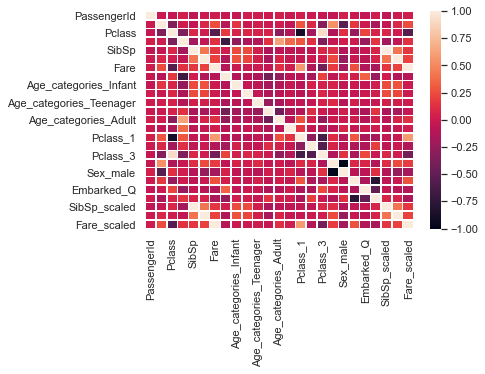

In [118]:
print(train.head()["Cabin"])
correlations = train.corr()
sns.heatmap(correlations, linewidths=0.5)
plt.show()